# 1. Importing modules and functions

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 2.Data entry and curation work set

In [4]:
uploaded_file_ws="datasets/HDAC6_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  3083 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [5]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [6]:
len(y_tr)

3083

# 3.Standardization SDF file for work set

In [7]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  3083 molecules


# 4.Data entry and curation test set

In [8]:
uploaded_file_ts="datasets/HDAC6_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  771 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [9]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [10]:
len(y_ts)

771

# 5.Standardization SDF file for test set

In [11]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  771 molecules


## Calculation RDKit_2D descriptors for work set

In [12]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [13]:
descr_tr= []
for m in moldf_ws:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [14]:
df_RDKit_2D = pd.DataFrame(x_tr,columns=header)

In [15]:
df_RDKit_2D.head(2)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.242419,12.242419,0.074853,-0.968233,0.872997,278.264,264.152,278.090272,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.174333,12.174333,0.042267,-0.371769,0.176840,416.909,391.709,416.161518,154.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [16]:
df_RDKit_2D.isna().mean().sort_values(ascending=False)

BCUT2D_MWLOW      0.003568
BCUT2D_LOGPLOW    0.003568
BCUT2D_CHGLO      0.003568
BCUT2D_CHGHI      0.003568
BCUT2D_MRHI       0.003568
                    ...   
SlogP_VSA8        0.000000
SlogP_VSA9        0.000000
TPSA              0.000000
EState_VSA1       0.000000
fr_urea           0.000000
Length: 209, dtype: float64

In [17]:
df_RDKit_2D=df_RDKit_2D.dropna(axis=1)
df_RDKit_2D

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.242419,12.242419,0.074853,-0.968233,0.872997,278.264,264.152,278.090272,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.174333,12.174333,0.042267,-0.371769,0.176840,416.909,391.709,416.161518,154.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,11.990951,11.990951,0.054892,-0.264842,0.815196,301.302,286.182,301.106256,114.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.873288,10.873288,0.534320,-0.534320,0.456792,213.236,202.148,213.078979,80.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.581454,2.581454,0.445824,0.445824,0.454787,272.476,240.220,272.250401,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,14.120048,14.120048,0.000665,-0.791896,0.586203,301.321,285.193,301.122655,114.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,12.247689,12.247689,0.057760,-0.384776,0.069031,516.606,484.350,516.259737,198.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3080,11.417085,11.417085,0.345049,-3.209919,0.425745,387.461,366.293,387.125277,142.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3081,12.132469,12.132469,0.021659,-0.374570,0.098503,504.595,472.339,504.259737,194.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [38]:
x_tr= df_RDKit_2D.to_numpy ()

In [41]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
Scaler=StandardScaler()
x_tr=Scaler.fit_transform(x_tr)

In [44]:
x_tr.shape

(3083, 197)

In [45]:
savetxt('Models/RDKiT/x_tr_RDKiT.csv', x_tr, delimiter=',')

## Calculation  RDKit_2D descriptors for test set

In [19]:
descr_ts = []
for m in moldf_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [20]:
x_ts.shape

(771, 209)

In [60]:
df_RDKit_2D_ts = pd.DataFrame(x_ts,columns=header)
df_RDKit_2D_ts=df_RDKit_2D_ts.dropna(axis=1)
df_RDKit_2D_ts

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.462074,10.462074,0.122184,-0.789763,0.825546,204.229,192.133,204.089878,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.347016,12.347016,0.044100,-0.408075,0.249061,494.720,448.352,494.350843,198.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11.705734,11.705734,0.208479,-0.548897,0.249396,446.547,416.307,446.220557,172.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.575602,13.575602,0.046998,-0.826780,0.142426,540.661,500.341,540.294785,212.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,11.474395,11.474395,0.062912,-0.557235,0.285460,338.433,316.257,338.141262,126.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,12.491330,12.491330,0.078379,-0.334371,0.199201,464.636,428.348,464.256960,178.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0
767,13.985815,13.985815,0.000132,-0.822281,0.592558,290.298,275.178,290.117904,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,14.047607,14.047607,0.154280,-1.051567,0.597350,323.274,311.178,323.088161,120.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769,12.260501,12.260501,0.092378,-0.391658,0.193074,396.447,372.255,396.179755,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [61]:
x_ts= df_RDKit_2D_ts.to_numpy ()

In [62]:
x_ts = Scaler.transform(x_ts)

In [21]:
# x_tr = np.array(x_tr, dtype=np.float32)
# y_tr = np.array(y_tr, dtype=np.float32)

 ## GradientBoostingRegressor model building and validation

In [46]:
seed = 42

In [47]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [48]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [49]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [50]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [51]:
best_GBR = m.best_estimator_

In [52]:
m.best_params_

{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}

In [53]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [54]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.99

In [55]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.26

In [56]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [57]:
y_pred_CV_GBR

array([5.06306428, 5.78054748, 4.9727082 , ..., 7.21720912, 7.9145829 ,
       7.03274436])

In [58]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.62

In [59]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.7

# 9. Prediction for test set's molecules

In [65]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

771

In [66]:
y_pred_GBR = best_GBR.predict(x_ts)

In [67]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.66

In [68]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.68

# save the model to disk

In [69]:
pickle.dump(best_GBR, open('Models/RDKiT/HDAC6_GBR_RDKiT.pkl', 'wb'))

# load the model from disk

In [20]:
best_GBR = pickle.load(open('Models/RDKiT/HDAC6_GBR_RDKiT.pkl', 'rb'))

# 10. Y-randomization GradientBoostingRegressor model

In [70]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 28.3min


True score =  0.62 
Y-randomization =  -0.2 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 51.7min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [71]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [72]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.900746,7.490754,4.863770,4.216553,17.930071,5.799908,12.561265,5.479323,7.492609,7.368469,...,4.920030,4.072734,4.076962,5.708168,0.658189,4.072734,4.407693,4.652277,3.443594,4.879563
2,7.109359,8.714100,6.138494,4.775836,17.975319,10.456244,13.250570,5.497795,7.601954,7.723112,...,5.171291,5.859728,4.348377,6.024628,0.988269,5.060231,5.224220,6.131215,4.407693,4.903584
3,8.137948,9.820561,6.308079,4.847588,18.707183,10.577019,13.336941,5.805781,7.664309,7.915602,...,6.813833,6.497852,4.839753,6.250507,1.010266,5.063000,5.662558,6.684642,4.833030,5.560298
4,9.989728,9.854204,7.085804,4.960749,18.861733,10.596407,13.549530,5.840825,9.903273,7.977096,...,7.405154,6.540346,5.370556,6.365888,1.255771,5.138347,6.034671,6.959352,4.916375,5.952220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.709452,57.090008,58.331396,58.048544,60.361909,59.614734,60.295796,56.343509,59.286559,57.215438,...,57.023795,58.033652,55.506057,57.839582,57.789266,57.883805,52.423024,58.245987,52.542843,58.314947
3079,64.622310,58.628856,61.113141,65.253094,66.739984,63.430776,64.864438,59.616123,60.062919,58.115876,...,58.553733,61.866145,58.377595,59.986568,61.820461,61.827141,59.121777,59.020775,59.263230,58.379989
3080,81.340502,75.280839,78.340686,82.818196,84.909101,80.951973,81.381164,74.253500,77.427874,74.428053,...,73.744194,78.953934,72.996767,77.820650,79.473150,79.284739,70.352530,76.791959,70.447545,76.546431
3081,85.425503,79.865417,82.594970,86.833621,88.959112,85.144143,85.474637,78.858671,81.937688,78.974006,...,78.352058,83.185009,77.640059,82.157241,83.693395,83.512267,75.306540,81.202237,75.398494,80.949962


In [73]:
similarity= neighbors_k

In [74]:
Dmean=np.mean(similarity[1,:])

In [75]:
round(Dmean, 2)

3.81

In [76]:
std=np.std(similarity[1,:])

In [77]:
round(std, 2)

2.93

In [78]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

5.28


In [79]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [80]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,5.562876,9.408307,2.476244,7.263118,5.282288,1.583892,4.525869,4.086624,1.226136,5.644353,...,3.599905,5.858725,2.397433,6.870954,0.624128,5.352804,4.178713,4.182506,2.802792,6.270563
1,6.275527,9.772277,3.742493,9.391857,5.966987,6.967967,4.654637,5.942024,1.366599,5.758951,...,4.647412,7.501709,2.406615,7.081888,1.123838,8.497024,4.706113,4.375260,6.100462,6.275194
2,9.078235,10.222067,5.327841,10.445792,6.363236,7.111340,4.662264,6.425875,2.359034,5.914622,...,4.780885,8.883466,3.993276,7.182392,1.419483,8.678516,5.038712,4.899669,6.551452,6.719943
3,9.173493,10.937669,5.398200,10.565662,6.781344,7.248561,4.665928,6.427113,8.193204,6.700883,...,4.980605,9.732865,4.486266,7.539695,1.828747,8.755605,6.219785,5.480123,6.700244,6.963034
4,10.453269,11.627252,8.801222,10.939350,6.816641,9.321835,4.682167,6.652034,9.358029,7.951190,...,5.120647,9.746281,6.545359,7.592781,2.017845,8.781171,6.347564,5.648499,6.784176,7.693971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.781460,56.179985,57.971633,52.362914,57.781897,58.591025,57.778069,51.572486,57.697751,57.476374,...,58.058852,59.868188,56.114015,54.404131,57.757386,54.564385,58.043730,58.252923,55.524112,54.207304
3079,67.205645,60.326141,58.778210,59.597604,59.279094,60.038208,62.331102,60.609191,58.992356,59.067913,...,61.397760,62.524080,59.718116,59.075142,61.826915,58.758203,62.399763,61.650949,58.134672,59.524069
3080,84.251754,74.074984,75.902602,70.851184,77.011702,75.895533,80.048812,71.155573,74.744390,74.372245,...,79.184990,79.435166,73.884777,73.209868,79.448739,72.676376,79.293186,78.995605,73.459662,71.604592
3081,88.179583,78.844858,80.434786,75.772136,81.400312,80.516987,84.226694,76.132504,79.301973,78.991110,...,83.416594,83.711997,78.526111,77.863150,83.664678,77.495521,83.496396,83.220802,78.117105,76.416846


In [81]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.56300e+00 9.40800e+00 2.47600e+00 7.26300e+00 5.28200e+00 1.58400e+00
 4.52600e+00 4.08700e+00 1.22600e+00 5.64400e+00 3.68800e+00 2.49300e+00
 1.16520e+01 5.60800e+00 1.98100e+00 2.12100e+00 1.44400e+00 5.20800e+00
 1.76500e+00 4.26400e+00 1.88300e+00 6.91600e+00 9.43100e+00 4.68400e+00
 1.49200e+01 2.24000e+00 2.77300e+00 7.36600e+00 1.96200e+00 4.84400e+00
 2.91800e+00 6.29500e+00 4.33100e+00 9.20700e+00 4.91700e+00 3.02300e+00
 4.15400e+00 5.92200e+00 5.15800e+00 4.62200e+00 7.16300e+00 3.86700e+00
 3.04700e+00 1.13160e+01 1.32220e+01 2.01300e+00 3.88900e+00 1.92400e+00
 3.34400e+00 3.48100e+00 4.09700e+00 1.64800e+00 7.86500e+00 1.32260e+01
 5.01000e+00 2.94400e+00 3.82500e+00 4.52400e+00 1.37280e+01 2.89200e+00
 1.03440e+01 2.26700e+00 3.71600e+00 5.77700e+00 6.72900e+00 6.57400e+00
 3.56200e+00 1.62200e+00 1.30300e+00 3.93600e+00 3.38100e+00 2.17900e+00
 1.41400e+00 8.35800e+00 1.30980e+01 2.54800e+00 7.36000e-01 6.53300e+00
 1.25400e+01 3.85900e+00 3.29900e+00 5.27200e+00 6.

In [82]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False False  True
 False  True  True False  True  True  True False  True False  True  True
  True False  True  True False  True  True False False  True  True  True
  True  True  True  True False False  True  True  True  True False  True
 False  True  True False False False  True  True  True  True  True  True
  True False False  True  True False False  True  True  True False  True
 False  True  True  True  True  True  True False  True False  True False
 False  True  True False  True False  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True  True False False  True  True
  True False  True  True  True  True  True  True  T

In [83]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [84]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   5   6   7   8  10  11  14  15  16  17  18  19  20  23  25  26  28
  29  30  32  34  35  36  38  39  41  42  45  46  47  48  49  50  51  54
  55  56  57  59  61  62  66  67  68  69  70  71  72  75  76  79  80  81
  83  85  86  87  88  89  90  92  94  97  98 100 102 105 106 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 129
 131 132 133 135 136 137 138 139 140 141 142 143 144 146 147 149 150 151
 154 155 156 158 159 160 161 162 163 164 165 166 169 170 172 173 174 175
 176 178 179 180 181 182 183 184 185 186 187 189 190 191 192 193 194 195
 196 197 198 199 200 202 203 204 205 206 207 208 210 211 214 215 217 218
 219 220 221 222 223 224 225 226 228 230 231 232 233 234 236 237 238 239
 240 241 244 245 246 248 249 251 252 253 254 256 257 258 259 261 262 263
 264 265 266 268 270 271 272 273 275 278 279 280 281 282 283 284 285 286
 287 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 30

In [85]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [86]:
y_pred_GBR_ad=list(y_pred_GBR)

In [87]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [88]:
len(y_pred_GBR_ad)

604

In [89]:
y_ts_ad=list(y_ts)

In [90]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [91]:
len(y_ts_ad)

604

In [92]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.7

In [93]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.64

# SVM model building and validation

In [94]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [95]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [96]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [97]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [98]:
svm.best_params_
best_svm = svm.best_estimator_

In [99]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [100]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [101]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.93

In [102]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.46

In [103]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [104]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.59

In [105]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.72

# 9. Prediction for test set's molecules

In [106]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [107]:
y_pred_svm = best_svm.predict(x_ts)

In [108]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.62

In [109]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.7

save the model to disk

In [110]:
pickle.dump(best_svm, open('Models/RDKiT/HDAC6_SVM_RDKiT.pkl', 'wb'))

load the model from disk

In [105]:
best_svm = pickle.load(open('Models/RDKiT/HDAC6_SVM_RDKiT.pkl', 'rb'))

# 10. Y-randomization SVM model

In [111]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   47.1s


True score =  0.588 
Y-randomization =  -0.38 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [112]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [113]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.900746,7.490754,4.863770,4.216553,17.930071,5.799908,12.561265,5.479323,7.492609,7.368469,...,4.920030,4.072734,4.076962,5.708168,0.658189,4.072734,4.407693,4.652277,3.443594,4.879563
2,7.109359,8.714100,6.138494,4.775836,17.975319,10.456244,13.250570,5.497795,7.601954,7.723112,...,5.171291,5.859728,4.348377,6.024628,0.988269,5.060231,5.224220,6.131215,4.407693,4.903584
3,8.137948,9.820561,6.308079,4.847588,18.707183,10.577019,13.336941,5.805781,7.664309,7.915602,...,6.813833,6.497852,4.839753,6.250507,1.010266,5.063000,5.662558,6.684642,4.833030,5.560298
4,9.989728,9.854204,7.085804,4.960749,18.861733,10.596407,13.549530,5.840825,9.903273,7.977096,...,7.405154,6.540346,5.370556,6.365888,1.255771,5.138347,6.034671,6.959352,4.916375,5.952220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.709452,57.090008,58.331396,58.048544,60.361909,59.614734,60.295796,56.343509,59.286559,57.215438,...,57.023795,58.033652,55.506057,57.839582,57.789266,57.883805,52.423024,58.245987,52.542843,58.314947
3079,64.622310,58.628856,61.113141,65.253094,66.739984,63.430776,64.864438,59.616123,60.062919,58.115876,...,58.553733,61.866145,58.377595,59.986568,61.820461,61.827141,59.121777,59.020775,59.263230,58.379989
3080,81.340502,75.280839,78.340686,82.818196,84.909101,80.951973,81.381164,74.253500,77.427874,74.428053,...,73.744194,78.953934,72.996767,77.820650,79.473150,79.284739,70.352530,76.791959,70.447545,76.546431
3081,85.425503,79.865417,82.594970,86.833621,88.959112,85.144143,85.474637,78.858671,81.937688,78.974006,...,78.352058,83.185009,77.640059,82.157241,83.693395,83.512267,75.306540,81.202237,75.398494,80.949962


In [114]:
similarity= neighbors_k

In [115]:
Dmean=np.mean(similarity[1,:])

In [116]:
round(Dmean, 2)

3.81

In [117]:
std=np.std(similarity[1,:])

In [118]:
round(std, 2)

2.93

In [119]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

5.28


In [120]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [121]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,5.562876,9.408307,2.476244,7.263118,5.282288,1.583892,4.525869,4.086624,1.226136,5.644353,...,3.599905,5.858725,2.397433,6.870954,0.624128,5.352804,4.178713,4.182506,2.802792,6.270563
1,6.275527,9.772277,3.742493,9.391857,5.966987,6.967967,4.654637,5.942024,1.366599,5.758951,...,4.647412,7.501709,2.406615,7.081888,1.123838,8.497024,4.706113,4.375260,6.100462,6.275194
2,9.078235,10.222067,5.327841,10.445792,6.363236,7.111340,4.662264,6.425875,2.359034,5.914622,...,4.780885,8.883466,3.993276,7.182392,1.419483,8.678516,5.038712,4.899669,6.551452,6.719943
3,9.173493,10.937669,5.398200,10.565662,6.781344,7.248561,4.665928,6.427113,8.193204,6.700883,...,4.980605,9.732865,4.486266,7.539695,1.828747,8.755605,6.219785,5.480123,6.700244,6.963034
4,10.453269,11.627252,8.801222,10.939350,6.816641,9.321835,4.682167,6.652034,9.358029,7.951190,...,5.120647,9.746281,6.545359,7.592781,2.017845,8.781171,6.347564,5.648499,6.784176,7.693971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.781460,56.179985,57.971633,52.362914,57.781897,58.591025,57.778069,51.572486,57.697751,57.476374,...,58.058852,59.868188,56.114015,54.404131,57.757386,54.564385,58.043730,58.252923,55.524112,54.207304
3079,67.205645,60.326141,58.778210,59.597604,59.279094,60.038208,62.331102,60.609191,58.992356,59.067913,...,61.397760,62.524080,59.718116,59.075142,61.826915,58.758203,62.399763,61.650949,58.134672,59.524069
3080,84.251754,74.074984,75.902602,70.851184,77.011702,75.895533,80.048812,71.155573,74.744390,74.372245,...,79.184990,79.435166,73.884777,73.209868,79.448739,72.676376,79.293186,78.995605,73.459662,71.604592
3081,88.179583,78.844858,80.434786,75.772136,81.400312,80.516987,84.226694,76.132504,79.301973,78.991110,...,83.416594,83.711997,78.526111,77.863150,83.664678,77.495521,83.496396,83.220802,78.117105,76.416846


In [122]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.56300e+00 9.40800e+00 2.47600e+00 7.26300e+00 5.28200e+00 1.58400e+00
 4.52600e+00 4.08700e+00 1.22600e+00 5.64400e+00 3.68800e+00 2.49300e+00
 1.16520e+01 5.60800e+00 1.98100e+00 2.12100e+00 1.44400e+00 5.20800e+00
 1.76500e+00 4.26400e+00 1.88300e+00 6.91600e+00 9.43100e+00 4.68400e+00
 1.49200e+01 2.24000e+00 2.77300e+00 7.36600e+00 1.96200e+00 4.84400e+00
 2.91800e+00 6.29500e+00 4.33100e+00 9.20700e+00 4.91700e+00 3.02300e+00
 4.15400e+00 5.92200e+00 5.15800e+00 4.62200e+00 7.16300e+00 3.86700e+00
 3.04700e+00 1.13160e+01 1.32220e+01 2.01300e+00 3.88900e+00 1.92400e+00
 3.34400e+00 3.48100e+00 4.09700e+00 1.64800e+00 7.86500e+00 1.32260e+01
 5.01000e+00 2.94400e+00 3.82500e+00 4.52400e+00 1.37280e+01 2.89200e+00
 1.03440e+01 2.26700e+00 3.71600e+00 5.77700e+00 6.72900e+00 6.57400e+00
 3.56200e+00 1.62200e+00 1.30300e+00 3.93600e+00 3.38100e+00 2.17900e+00
 1.41400e+00 8.35800e+00 1.30980e+01 2.54800e+00 7.36000e-01 6.53300e+00
 1.25400e+01 3.85900e+00 3.29900e+00 5.27200e+00 6.

In [123]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False False  True
 False  True  True False  True  True  True False  True False  True  True
  True False  True  True False  True  True False False  True  True  True
  True  True  True  True False False  True  True  True  True False  True
 False  True  True False False False  True  True  True  True  True  True
  True False False  True  True False False  True  True  True False  True
 False  True  True  True  True  True  True False  True False  True False
 False  True  True False  True False  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True  True False False  True  True
  True False  True  True  True  True  True  True  T

In [124]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [125]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   5   6   7   8  10  11  14  15  16  17  18  19  20  23  25  26  28
  29  30  32  34  35  36  38  39  41  42  45  46  47  48  49  50  51  54
  55  56  57  59  61  62  66  67  68  69  70  71  72  75  76  79  80  81
  83  85  86  87  88  89  90  92  94  97  98 100 102 105 106 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 129
 131 132 133 135 136 137 138 139 140 141 142 143 144 146 147 149 150 151
 154 155 156 158 159 160 161 162 163 164 165 166 169 170 172 173 174 175
 176 178 179 180 181 182 183 184 185 186 187 189 190 191 192 193 194 195
 196 197 198 199 200 202 203 204 205 206 207 208 210 211 214 215 217 218
 219 220 221 222 223 224 225 226 228 230 231 232 233 234 236 237 238 239
 240 241 244 245 246 248 249 251 252 253 254 256 257 258 259 261 262 263
 264 265 266 268 270 271 272 273 275 278 279 280 281 282 283 284 285 286
 287 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 30

In [126]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [127]:
y_pred_svm_ad=list(y_pred_svm)

In [128]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [129]:
len(y_pred_svm_ad)

604

In [130]:
y_ts_ad=list(y_ts)

In [131]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [132]:
len(y_ts_ad)

604

In [133]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.68

In [134]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.65

# Multi-layer Perceptron regressor

In [135]:
from sklearn.neural_network import MLPRegressor

In [136]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [137]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [138]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [139]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [140]:
best_MLPR = m.best_estimator_

In [141]:
m.best_params_

{'activation': 'tanh',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'sgd'}

In [142]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [143]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.97

In [144]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.36

In [145]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [146]:
y_pred_CV_MLPR

array([3.80631561, 5.77715057, 5.12889472, ..., 7.03837085, 7.96059936,
       6.27213792])

In [147]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.45

In [148]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.77

# 9. Prediction for test set's molecules

In [149]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [150]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [151]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.55

In [152]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.74

# save the model to disk

In [153]:
pickle.dump(best_MLPR, open('Models/RDKiT/HDAC6_MLPR_RDKiT.pkl', 'wb'))

# load the model from disk

In [83]:
best_MLPR = pickle.load(open('Models/RDKiT/HDAC6_MLPR_RDKiT.pkl', 'rb'))

# 10. Y-randomization MLPR

In [154]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 87.4min


True score =  0.45 
Y-randomization =  -0.96 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 137.6min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [155]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [156]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.900746,7.490754,4.863770,4.216553,17.930071,5.799908,12.561265,5.479323,7.492609,7.368469,...,4.920030,4.072734,4.076962,5.708168,0.658189,4.072734,4.407693,4.652277,3.443594,4.879563
2,7.109359,8.714100,6.138494,4.775836,17.975319,10.456244,13.250570,5.497795,7.601954,7.723112,...,5.171291,5.859728,4.348377,6.024628,0.988269,5.060231,5.224220,6.131215,4.407693,4.903584
3,8.137948,9.820561,6.308079,4.847588,18.707183,10.577019,13.336941,5.805781,7.664309,7.915602,...,6.813833,6.497852,4.839753,6.250507,1.010266,5.063000,5.662558,6.684642,4.833030,5.560298
4,9.989728,9.854204,7.085804,4.960749,18.861733,10.596407,13.549530,5.840825,9.903273,7.977096,...,7.405154,6.540346,5.370556,6.365888,1.255771,5.138347,6.034671,6.959352,4.916375,5.952220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.709452,57.090008,58.331396,58.048544,60.361909,59.614734,60.295796,56.343509,59.286559,57.215438,...,57.023795,58.033652,55.506057,57.839582,57.789266,57.883805,52.423024,58.245987,52.542843,58.314947
3079,64.622310,58.628856,61.113141,65.253094,66.739984,63.430776,64.864438,59.616123,60.062919,58.115876,...,58.553733,61.866145,58.377595,59.986568,61.820461,61.827141,59.121777,59.020775,59.263230,58.379989
3080,81.340502,75.280839,78.340686,82.818196,84.909101,80.951973,81.381164,74.253500,77.427874,74.428053,...,73.744194,78.953934,72.996767,77.820650,79.473150,79.284739,70.352530,76.791959,70.447545,76.546431
3081,85.425503,79.865417,82.594970,86.833621,88.959112,85.144143,85.474637,78.858671,81.937688,78.974006,...,78.352058,83.185009,77.640059,82.157241,83.693395,83.512267,75.306540,81.202237,75.398494,80.949962


In [157]:
similarity= neighbors_k

In [158]:
Dmean=np.mean(similarity[1,:])

In [159]:
round(Dmean, 2)

3.81

In [160]:
std=np.std(similarity[1,:])

In [161]:
round(std, 2)

2.93

In [162]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

5.28


In [163]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [164]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,5.562876,9.408307,2.476244,7.263118,5.282288,1.583892,4.525869,4.086624,1.226136,5.644353,...,3.599905,5.858725,2.397433,6.870954,0.624128,5.352804,4.178713,4.182506,2.802792,6.270563
1,6.275527,9.772277,3.742493,9.391857,5.966987,6.967967,4.654637,5.942024,1.366599,5.758951,...,4.647412,7.501709,2.406615,7.081888,1.123838,8.497024,4.706113,4.375260,6.100462,6.275194
2,9.078235,10.222067,5.327841,10.445792,6.363236,7.111340,4.662264,6.425875,2.359034,5.914622,...,4.780885,8.883466,3.993276,7.182392,1.419483,8.678516,5.038712,4.899669,6.551452,6.719943
3,9.173493,10.937669,5.398200,10.565662,6.781344,7.248561,4.665928,6.427113,8.193204,6.700883,...,4.980605,9.732865,4.486266,7.539695,1.828747,8.755605,6.219785,5.480123,6.700244,6.963034
4,10.453269,11.627252,8.801222,10.939350,6.816641,9.321835,4.682167,6.652034,9.358029,7.951190,...,5.120647,9.746281,6.545359,7.592781,2.017845,8.781171,6.347564,5.648499,6.784176,7.693971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.781460,56.179985,57.971633,52.362914,57.781897,58.591025,57.778069,51.572486,57.697751,57.476374,...,58.058852,59.868188,56.114015,54.404131,57.757386,54.564385,58.043730,58.252923,55.524112,54.207304
3079,67.205645,60.326141,58.778210,59.597604,59.279094,60.038208,62.331102,60.609191,58.992356,59.067913,...,61.397760,62.524080,59.718116,59.075142,61.826915,58.758203,62.399763,61.650949,58.134672,59.524069
3080,84.251754,74.074984,75.902602,70.851184,77.011702,75.895533,80.048812,71.155573,74.744390,74.372245,...,79.184990,79.435166,73.884777,73.209868,79.448739,72.676376,79.293186,78.995605,73.459662,71.604592
3081,88.179583,78.844858,80.434786,75.772136,81.400312,80.516987,84.226694,76.132504,79.301973,78.991110,...,83.416594,83.711997,78.526111,77.863150,83.664678,77.495521,83.496396,83.220802,78.117105,76.416846


In [165]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.56300e+00 9.40800e+00 2.47600e+00 7.26300e+00 5.28200e+00 1.58400e+00
 4.52600e+00 4.08700e+00 1.22600e+00 5.64400e+00 3.68800e+00 2.49300e+00
 1.16520e+01 5.60800e+00 1.98100e+00 2.12100e+00 1.44400e+00 5.20800e+00
 1.76500e+00 4.26400e+00 1.88300e+00 6.91600e+00 9.43100e+00 4.68400e+00
 1.49200e+01 2.24000e+00 2.77300e+00 7.36600e+00 1.96200e+00 4.84400e+00
 2.91800e+00 6.29500e+00 4.33100e+00 9.20700e+00 4.91700e+00 3.02300e+00
 4.15400e+00 5.92200e+00 5.15800e+00 4.62200e+00 7.16300e+00 3.86700e+00
 3.04700e+00 1.13160e+01 1.32220e+01 2.01300e+00 3.88900e+00 1.92400e+00
 3.34400e+00 3.48100e+00 4.09700e+00 1.64800e+00 7.86500e+00 1.32260e+01
 5.01000e+00 2.94400e+00 3.82500e+00 4.52400e+00 1.37280e+01 2.89200e+00
 1.03440e+01 2.26700e+00 3.71600e+00 5.77700e+00 6.72900e+00 6.57400e+00
 3.56200e+00 1.62200e+00 1.30300e+00 3.93600e+00 3.38100e+00 2.17900e+00
 1.41400e+00 8.35800e+00 1.30980e+01 2.54800e+00 7.36000e-01 6.53300e+00
 1.25400e+01 3.85900e+00 3.29900e+00 5.27200e+00 6.

In [166]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False False  True
 False  True  True False  True  True  True False  True False  True  True
  True False  True  True False  True  True False False  True  True  True
  True  True  True  True False False  True  True  True  True False  True
 False  True  True False False False  True  True  True  True  True  True
  True False False  True  True False False  True  True  True False  True
 False  True  True  True  True  True  True False  True False  True False
 False  True  True False  True False  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True  True False False  True  True
  True False  True  True  True  True  True  True  T

In [167]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [168]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   5   6   7   8  10  11  14  15  16  17  18  19  20  23  25  26  28
  29  30  32  34  35  36  38  39  41  42  45  46  47  48  49  50  51  54
  55  56  57  59  61  62  66  67  68  69  70  71  72  75  76  79  80  81
  83  85  86  87  88  89  90  92  94  97  98 100 102 105 106 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 129
 131 132 133 135 136 137 138 139 140 141 142 143 144 146 147 149 150 151
 154 155 156 158 159 160 161 162 163 164 165 166 169 170 172 173 174 175
 176 178 179 180 181 182 183 184 185 186 187 189 190 191 192 193 194 195
 196 197 198 199 200 202 203 204 205 206 207 208 210 211 214 215 217 218
 219 220 221 222 223 224 225 226 228 230 231 232 233 234 236 237 238 239
 240 241 244 245 246 248 249 251 252 253 254 256 257 258 259 261 262 263
 264 265 266 268 270 271 272 273 275 278 279 280 281 282 283 284 285 286
 287 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 30

In [169]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [170]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [171]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [172]:
len(y_pred_MLPR_ad)

604

In [173]:
y_ts_ad=list(y_ts)

In [174]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [175]:
len(y_ts_ad)

604

In [176]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.65

In [177]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.68

# k-nearest neighbors

In [178]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [179]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [180]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [181]:
best_kNN = m.best_estimator_

In [182]:
m.best_params_

{'n_neighbors': 3}

In [183]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [184]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.79

In [185]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.59

In [186]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [187]:
y_pred_CV_kNN

array([4.261667 , 6.16     , 4.7666664, ..., 5.9933333, 8.18     ,
       6.5416665], dtype=float32)

In [188]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.53

In [189]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.74

# 9. Prediction for test set's molecules

In [190]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [191]:
y_pred_kNN = best_kNN.predict(x_ts)

In [192]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.55

In [193]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.73

# save the model to disk

In [194]:
pickle.dump(best_kNN, open('Models/RDKiT/HDAC6_kNN_RDKiT.pkl', 'wb'))

# load the model from disk

In [190]:
best_kNN = pickle.load(open('Models/RDKiT/HDAC6_kNN_RDKiT.pkl', 'rb'))

# 10. Y-randomization MLPR

In [195]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


True score =  0.52 
Y-randomization =  -0.34 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [196]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [197]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.900746,7.490754,4.863770,4.216553,17.930071,5.799908,12.561265,5.479323,7.492609,7.368469,...,4.920030,4.072734,4.076962,5.708168,0.658189,4.072734,4.407693,4.652277,3.443594,4.879563
2,7.109359,8.714100,6.138494,4.775836,17.975319,10.456244,13.250570,5.497795,7.601954,7.723112,...,5.171291,5.859728,4.348377,6.024628,0.988269,5.060231,5.224220,6.131215,4.407693,4.903584
3,8.137948,9.820561,6.308079,4.847588,18.707183,10.577019,13.336941,5.805781,7.664309,7.915602,...,6.813833,6.497852,4.839753,6.250507,1.010266,5.063000,5.662558,6.684642,4.833030,5.560298
4,9.989728,9.854204,7.085804,4.960749,18.861733,10.596407,13.549530,5.840825,9.903273,7.977096,...,7.405154,6.540346,5.370556,6.365888,1.255771,5.138347,6.034671,6.959352,4.916375,5.952220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.709452,57.090008,58.331396,58.048544,60.361909,59.614734,60.295796,56.343509,59.286559,57.215438,...,57.023795,58.033652,55.506057,57.839582,57.789266,57.883805,52.423024,58.245987,52.542843,58.314947
3079,64.622310,58.628856,61.113141,65.253094,66.739984,63.430776,64.864438,59.616123,60.062919,58.115876,...,58.553733,61.866145,58.377595,59.986568,61.820461,61.827141,59.121777,59.020775,59.263230,58.379989
3080,81.340502,75.280839,78.340686,82.818196,84.909101,80.951973,81.381164,74.253500,77.427874,74.428053,...,73.744194,78.953934,72.996767,77.820650,79.473150,79.284739,70.352530,76.791959,70.447545,76.546431
3081,85.425503,79.865417,82.594970,86.833621,88.959112,85.144143,85.474637,78.858671,81.937688,78.974006,...,78.352058,83.185009,77.640059,82.157241,83.693395,83.512267,75.306540,81.202237,75.398494,80.949962


In [198]:
similarity= neighbors_k

In [199]:
Dmean=np.mean(similarity[1,:])

In [200]:
round(Dmean, 2)

3.81

In [201]:
std=np.std(similarity[1,:])

In [202]:
round(std, 2)

2.93

In [203]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

5.28


In [204]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [205]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,5.562876,9.408307,2.476244,7.263118,5.282288,1.583892,4.525869,4.086624,1.226136,5.644353,...,3.599905,5.858725,2.397433,6.870954,0.624128,5.352804,4.178713,4.182506,2.802792,6.270563
1,6.275527,9.772277,3.742493,9.391857,5.966987,6.967967,4.654637,5.942024,1.366599,5.758951,...,4.647412,7.501709,2.406615,7.081888,1.123838,8.497024,4.706113,4.375260,6.100462,6.275194
2,9.078235,10.222067,5.327841,10.445792,6.363236,7.111340,4.662264,6.425875,2.359034,5.914622,...,4.780885,8.883466,3.993276,7.182392,1.419483,8.678516,5.038712,4.899669,6.551452,6.719943
3,9.173493,10.937669,5.398200,10.565662,6.781344,7.248561,4.665928,6.427113,8.193204,6.700883,...,4.980605,9.732865,4.486266,7.539695,1.828747,8.755605,6.219785,5.480123,6.700244,6.963034
4,10.453269,11.627252,8.801222,10.939350,6.816641,9.321835,4.682167,6.652034,9.358029,7.951190,...,5.120647,9.746281,6.545359,7.592781,2.017845,8.781171,6.347564,5.648499,6.784176,7.693971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,59.781460,56.179985,57.971633,52.362914,57.781897,58.591025,57.778069,51.572486,57.697751,57.476374,...,58.058852,59.868188,56.114015,54.404131,57.757386,54.564385,58.043730,58.252923,55.524112,54.207304
3079,67.205645,60.326141,58.778210,59.597604,59.279094,60.038208,62.331102,60.609191,58.992356,59.067913,...,61.397760,62.524080,59.718116,59.075142,61.826915,58.758203,62.399763,61.650949,58.134672,59.524069
3080,84.251754,74.074984,75.902602,70.851184,77.011702,75.895533,80.048812,71.155573,74.744390,74.372245,...,79.184990,79.435166,73.884777,73.209868,79.448739,72.676376,79.293186,78.995605,73.459662,71.604592
3081,88.179583,78.844858,80.434786,75.772136,81.400312,80.516987,84.226694,76.132504,79.301973,78.991110,...,83.416594,83.711997,78.526111,77.863150,83.664678,77.495521,83.496396,83.220802,78.117105,76.416846


In [206]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.56300e+00 9.40800e+00 2.47600e+00 7.26300e+00 5.28200e+00 1.58400e+00
 4.52600e+00 4.08700e+00 1.22600e+00 5.64400e+00 3.68800e+00 2.49300e+00
 1.16520e+01 5.60800e+00 1.98100e+00 2.12100e+00 1.44400e+00 5.20800e+00
 1.76500e+00 4.26400e+00 1.88300e+00 6.91600e+00 9.43100e+00 4.68400e+00
 1.49200e+01 2.24000e+00 2.77300e+00 7.36600e+00 1.96200e+00 4.84400e+00
 2.91800e+00 6.29500e+00 4.33100e+00 9.20700e+00 4.91700e+00 3.02300e+00
 4.15400e+00 5.92200e+00 5.15800e+00 4.62200e+00 7.16300e+00 3.86700e+00
 3.04700e+00 1.13160e+01 1.32220e+01 2.01300e+00 3.88900e+00 1.92400e+00
 3.34400e+00 3.48100e+00 4.09700e+00 1.64800e+00 7.86500e+00 1.32260e+01
 5.01000e+00 2.94400e+00 3.82500e+00 4.52400e+00 1.37280e+01 2.89200e+00
 1.03440e+01 2.26700e+00 3.71600e+00 5.77700e+00 6.72900e+00 6.57400e+00
 3.56200e+00 1.62200e+00 1.30300e+00 3.93600e+00 3.38100e+00 2.17900e+00
 1.41400e+00 8.35800e+00 1.30980e+01 2.54800e+00 7.36000e-01 6.53300e+00
 1.25400e+01 3.85900e+00 3.29900e+00 5.27200e+00 6.

In [207]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True False False  True
 False  True  True False  True  True  True False  True False  True  True
  True False  True  True False  True  True False False  True  True  True
  True  True  True  True False False  True  True  True  True False  True
 False  True  True False False False  True  True  True  True  True  True
  True False False  True  True False False  True  True  True False  True
 False  True  True  True  True  True  True False  True False  True False
 False  True  True False  True False  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True False  True  True  True  True  True  True  True  True  True
  True False  True  True False  True  True  True False False  True  True
  True False  True  True  True  True  True  True  T

In [208]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [209]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   5   6   7   8  10  11  14  15  16  17  18  19  20  23  25  26  28
  29  30  32  34  35  36  38  39  41  42  45  46  47  48  49  50  51  54
  55  56  57  59  61  62  66  67  68  69  70  71  72  75  76  79  80  81
  83  85  86  87  88  89  90  92  94  97  98 100 102 105 106 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126 127 129
 131 132 133 135 136 137 138 139 140 141 142 143 144 146 147 149 150 151
 154 155 156 158 159 160 161 162 163 164 165 166 169 170 172 173 174 175
 176 178 179 180 181 182 183 184 185 186 187 189 190 191 192 193 194 195
 196 197 198 199 200 202 203 204 205 206 207 208 210 211 214 215 217 218
 219 220 221 222 223 224 225 226 228 230 231 232 233 234 236 237 238 239
 240 241 244 245 246 248 249 251 252 253 254 256 257 258 259 261 262 263
 264 265 266 268 270 271 272 273 275 278 279 280 281 282 283 284 285 286
 287 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 30

In [210]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [211]:
y_pred_kNN_ad=list(y_pred_kNN)

In [212]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [213]:
len(y_pred_kNN_ad)

604

In [214]:
y_ts_ad=list(y_ts)

In [215]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [216]:
len(y_ts_ad)

604

In [217]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.62

In [218]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.69

 # Analyzing the importance of descriptors for the GBM model

In [219]:
import shap

In [220]:
explainer = shap.Explainer(best_GBR)

In [222]:
shap_values = explainer(x_tr)

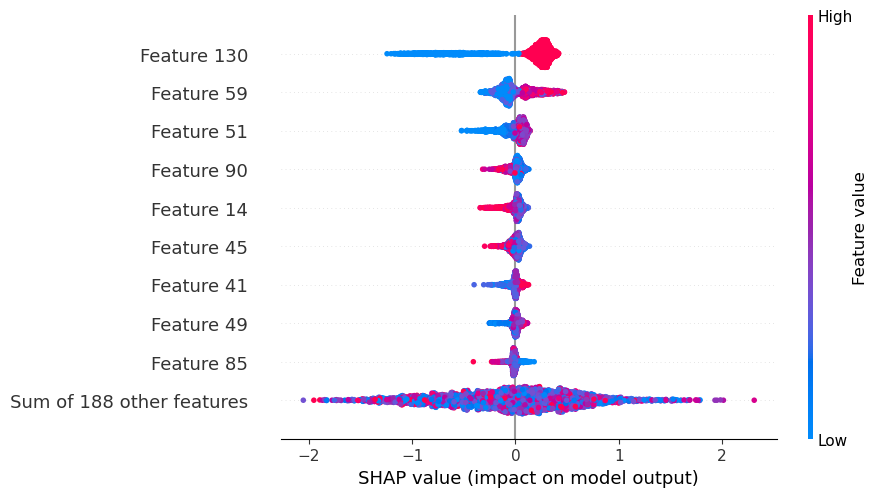

In [223]:
shap.plots.beeswarm(shap_values)

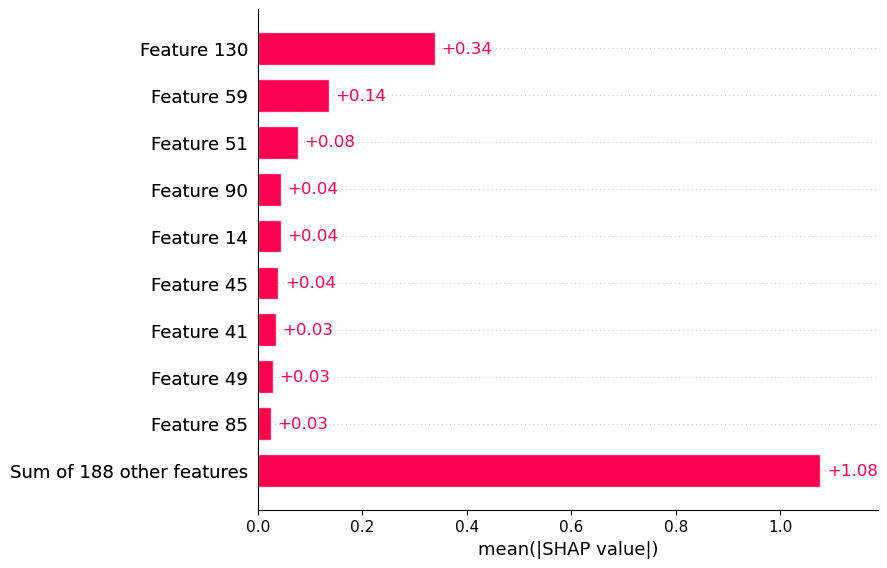

In [224]:
shap.plots.bar(shap_values)